In [1]:
import os

import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
tf.keras.backend.set_floatx('float64')
from tensorflow.keras import Model
from flow_layers import parametric_real_nvp # For vector parameteric maps

# Plotting
import matplotlib.pyplot as plt

In [2]:
def StableVariable(m, alpha):
    V = np.pi/2 * (2*np.random.rand(m)-1)
    W = np.random.exponential(scale=1, size=m)
    y = np.sin(alpha * V) / (np.cos(V)**(1/alpha) ) * (np.cos( V*(1-alpha)) / W )**((1-alpha)/alpha)
    return y

def data_generation(T, dt, n_samples):
    t = np.arange(0, T, dt)
    
    Nt = len(t)
    # #multimodal initial distribution
    # mu = np.array([[2, 3]])
    # sigma = np.eye(2)
    # X0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    # XX0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    
    
    #single-mode initial distribution
    X0 = np.random.randn(n_samples//2,2)
    XX0 = np.random.randn(n_samples//2,2)
    
    # #fixed initial value
    # X0 = np.ones([n_samples//2,2])
    # XX0 = np.ones([n_samples//2,2])   
    
    
    x0 = X0[:,0:1]
    xx0 = XX0[:,0:1]
    y0 = X0[:,1:]
    yy0 = XX0[:,1:]
    N = len(x0) + len(xx0)
    alpha = 1.5
    x = np.zeros((Nt, N))
    y = np.zeros((Nt, N))
    x[0, 0:n_samples//2] = x0.squeeze()
    x[0, n_samples//2:n_samples] = xx0.squeeze()
    y[0, 0:n_samples//2] = y0.squeeze()
    y[0, n_samples//2:n_samples] = yy0.squeeze()
    for i in range(Nt-1):
        Ut = dt**(1/alpha) * StableVariable(N, alpha)
        Vt = dt**(1/alpha) * StableVariable(N, alpha)
        UUt = dt**(1/2) * np.random.randn(N)
        VVt = dt**(1/2) * np.random.randn(N)
        # #Multimodal case
        # x[i+1, :] = x[i, :] + (8*x[i, :] - 1*x[i, :]**3)*dt + 0*x[i, :]*UUt+ 1*UUt
        # y[i+1, :] = y[i, :] + (8*y[i, :] - 1*y[i, :]**3)*dt + 0*y[i, :]*VVt + 1*VVt
        
        # #Unimodal case
        x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
        y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
     
        b=np.empty(0).astype(int)
        for j in range(n_samples):
            if (np.abs(x[:,j])>1e4).any() or (np.abs(y[:,j])>1e4).any():
                b = np.append(b,j)
        x1 = np.delete(x,b,axis=1)
        y1 = np.delete(y,b,axis=1)
    return t.astype('float64'), x1.astype('float64'), y1.astype('float64')

#Build the model which does basic map of inputs to coefficients
class normalizing_flow(Model):
    def __init__(self,data,params):
        super(normalizing_flow, self).__init__()

        self.dim = data.shape[1]
        self.data = data
        self.params = params

        # Define real_nvp flow layers
        self.l0 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l1 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l2 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l3 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        

        # Training optimizer
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)

        # Moving statistics
        self.moving_mean = None
        self.moving_std = None

    @tf.function
    def call(self, x, params): # x to z (forward)

        h1, ldj1 = self.l0(x,params) # Individual layer calls
        h2, ldj2 = self.l1(h1,params)
        h3, ldj3 = self.l2(h2,params)
        hfinal, ldj4 = self.l3(h3,params)

        logdet = ldj1+ldj2+ldj3+ldj4

        log_prior = -0.5*tf.math.reduce_sum(tf.math.square(hfinal))

        neg_ll = - log_prior - logdet

        return hfinal, neg_ll

    @tf.function
    def call_backward(self,z,params): # z to x

        h = self.l3.invert(z,params) # Individual layer calls
        h = self.l2.invert(h,params) # Individual layer calls
        h = self.l1.invert(h,params) # Individual layer calls
        h = self.l0.invert(h,params) # Individual layer calls

        return h

    # perform gradient descent
    @tf.function
    def network_learn(self,x,params):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            _, neg_ll = self.call(x,params)
            g = tape.gradient(neg_ll, self.trainable_variables)

        self.train_op.apply_gradients(zip(g, self.trainable_variables))

    @tf.function
    def extract_gradient(self,input_grad,params):
        params = tf.convert_to_tensor(params)
        z = tf.convert_to_tensor(input_grad)
        
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(z)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(params)
                with tf.GradientTape(persistent=True) as tape3:
                    tape3.watch(params)
                    x = self.call_backward(z,params)
    
                g1 = tape3.batch_jacobian(x, params)
            g2 = tape2.batch_jacobian(g1, params)
        v = tape1.batch_jacobian(g1, z)
        
        return g1, g2, v

    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 10
        best_valid_loss = np.inf # Some large number 

        self.num_batches = 10
        self.ntrain = int(0.7*self.data.shape[0])
        self.nvalid = self.data.shape[0] - int(0.7*self.data.shape[0])

        self.train_data = self.data[:self.ntrain]
        self.train_params = self.params[:self.ntrain]

        self.valid_data = self.data[self.ntrain:]
        self.valid_params = self.params[self.ntrain:]

        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int(self.ntrain/self.num_batches)
        
        for i in range(2000):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                batch_data = self.train_data[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                batch_params = self.train_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(batch_data,batch_params)

            # Validation loss
            valid_loss = 0.0

            for batch in range(self.num_batches):
                batch_data = self.valid_data[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                batch_params = self.valid_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                valid_loss = valid_loss + np.sum(self.call(batch_data,batch_params)[1].numpy())

            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation negative log likelihood from:',best_valid_loss,' to:', valid_loss)
                
                best_valid_loss = valid_loss

                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation negative log likelihood (no improvement):',valid_loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                self.train_op._hyper['learning_rate'] = 0.5*self.train_op._hyper['learning_rate']
                print('Reduced learning rate to',self.train_op._hyper['learning_rate'])
                stop_iter = 0
                
                if self.train_op._hyper['learning_rate'] < 1e-6:
                    break

def visualize_samples(samples,params,time=0,eps=0.1):
    # At a specific time
    plot_samples = []
    for i in range(params.shape[0]):
        if params[i,0] < time+eps and params[i,0] > time-eps:
            plot_samples.append(samples[i])

    plot_samples = np.asarray(plot_samples)

    plt.figure()
    plt.scatter(plot_samples[:,0],plot_samples[:,1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Density at time:'+str(time))
    plt.show()

In [3]:
train_mode = False

final_time = 1.0
timestep = 0.001
num_samples = 400
t, x, y = data_generation(final_time,timestep,num_samples)
t = np.repeat(t.reshape(-1,1),num_samples,axis=-1)

In [4]:
idx = np.arange(start=0,stop=t.shape[1])
np.random.shuffle(idx)

x_train = x[:,idx].reshape(-1,1)
y_train = y[:,idx].reshape(-1,1)
train_data = np.concatenate((x_train,y_train),axis=-1)
train_params = t[:,idx].reshape(-1,1)

In [5]:
# Normalizing flow training
flow_model = normalizing_flow(train_data,train_params)
z = np.random.normal(size=train_data.shape)
pre_samples = flow_model.call_backward(z,train_params) # Forward is x to z, Backward is z to x
pre_samples = pre_samples.numpy()

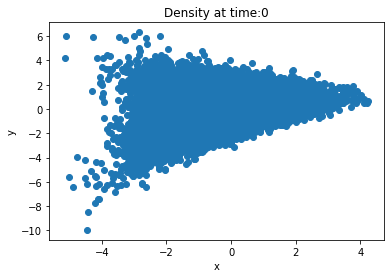

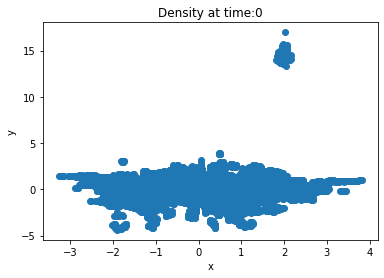

In [6]:
visualize_samples(pre_samples,train_params,time=0)
visualize_samples(train_data,train_params,time=0)

In [6]:
if train_mode:
    flow_model.train_model()
    flow_model.load_weights('./checkpoints/my_checkpoint')
else:
    flow_model.load_weights('./checkpoints/my_checkpoint')

In [7]:
z = np.random.normal(size=train_data.shape)
post_samples = flow_model.call_backward(z,train_params)
post_samples = post_samples.numpy()

In [8]:
# # At a specific time
# for time in np.arange(0.0,final_time,0.1):
    
#     eps = 0.1
#     plot_samples = []
#     target_samples = []

#     for i in range(train_params.shape[0]):
#         if train_params[i,0] < time+eps and train_params[i,0] > time-eps:
#             plot_samples.append(post_samples[i])
#             target_samples.append(train_data[i])

#     plot_samples = np.asarray(plot_samples)
#     target_samples = np.asarray(target_samples)

#     plt.figure()
#     plt.scatter(plot_samples[:,0],plot_samples[:,1],label='Generated',alpha=0.2)
#     plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2,label='True')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.xlim((-10,40))
#     plt.ylim((-40,40))
#     plt.title('Density at time:'+str(time))
#     plt.legend()
#     plt.show()

In [8]:
zx = np.linspace(-1, 1, 200)
zy = np.linspace(-1, 1, 200)

zxv, zyv = np.meshgrid(zx, zy)
zxvflat = zxv.reshape(-1,1)
zyvflat = zyv.reshape(-1,1)

grid = np.concatenate((zxvflat,zyvflat),axis=-1)
params = np.zeros(shape=(grid.shape[0],1))

### Extracting the gradients etc and plotting

/home/rmlans/miniconda3/envs/tf2_env/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Reshape:0", shape=(None, 40000), dtype=float64), dense_shape=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


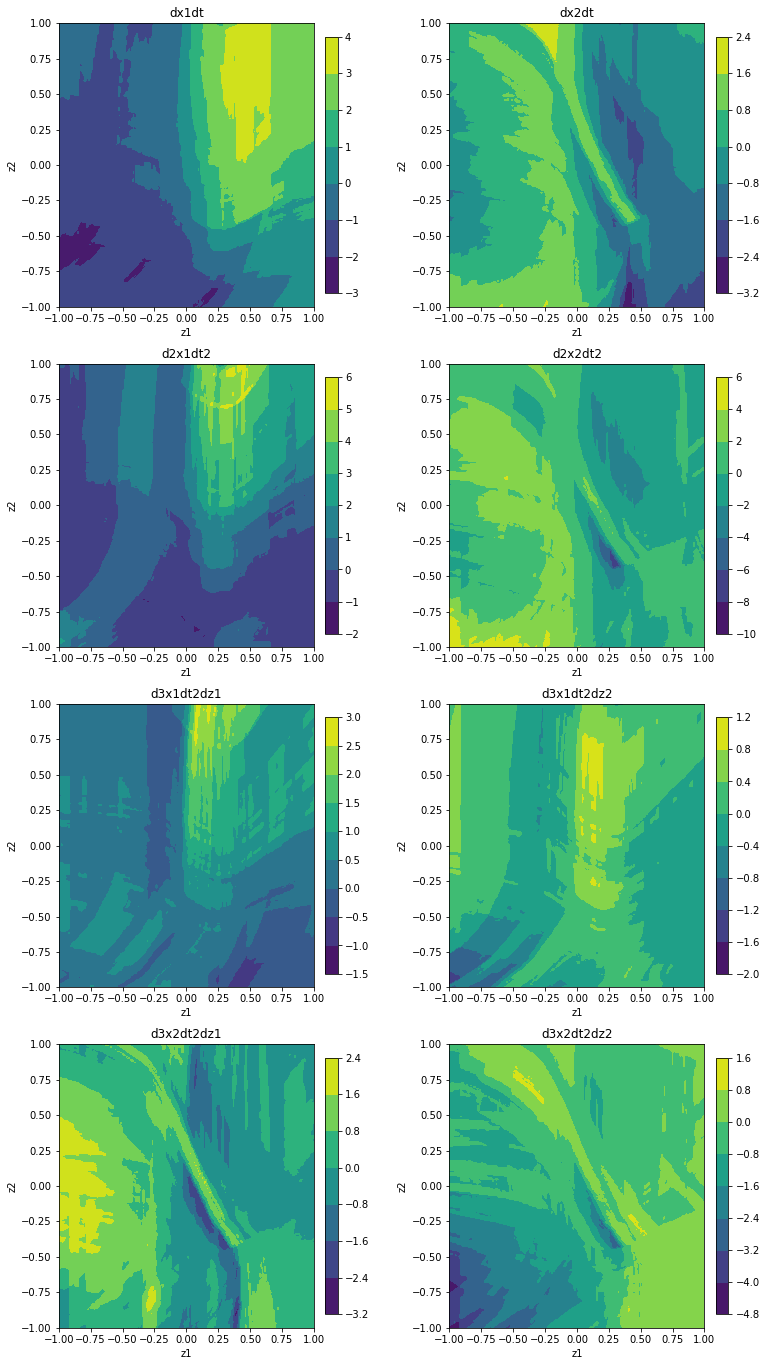

In [9]:
params[:,0] = 0.0
g1, g2, v = flow_model.extract_gradient(grid,params)

# Gradient of x1, x2 with respect to t (velocity)
dx1dt = g1.numpy()[:,0,0].reshape(zx.shape[0],zy.shape[0])
dx2dt = g1.numpy()[:,1,0].reshape(zx.shape[0],zy.shape[0])

# Second derivative of x1, x2 with respect to t (acceleration)
d2x1dt2 = g2.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
d2x2dt2 = g2.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])

# Derivative of velocity with respect to z1, z2 (directional derivative of velocity)
d3x1dt2dz1 = v.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
d3x1dt2dz2 = v.numpy()[:,0,0,1].reshape(zx.shape[0],zy.shape[0])
d3x2dt2dz1 = v.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])
d3x2dt2dz2 = v.numpy()[:,1,0,1].reshape(zx.shape[0],zy.shape[0])

fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(12,24))


cs1 = ax[0,0].contourf(zxv,zyv,dx1dt)#,levels=levels)
ax[0,0].set_title('dx1dt')
cs2 = ax[0,1].contourf(zxv,zyv,dx2dt)#,levels=levels)
ax[0,1].set_title('dx2dt')
cs3 = ax[1,0].contourf(zxv,zyv,d2x1dt2)#,levels=levels)
ax[1,0].set_title('d2x1dt2')
cs4 = ax[1,1].contourf(zxv,zyv,d2x2dt2)#,levels=levels)
ax[1,1].set_title('d2x2dt2')

cs5 = ax[2,0].contourf(zxv,zyv,d3x1dt2dz1)#,levels=levels)
ax[2,0].set_title('d3x1dt2dz1')

cs6 = ax[2,1].contourf(zxv,zyv,d3x1dt2dz2)#,levels=levels)
ax[2,1].set_title('d3x1dt2dz2')

cs7 = ax[3,0].contourf(zxv,zyv,d3x2dt2dz1)#,levels=levels)
ax[3,0].set_title('d3x2dt2dz1')

cs8 = ax[3,1].contourf(zxv,zyv,d3x2dt2dz2)#,levels=levels)
ax[3,1].set_title('d3x2dt2dz2')


for i in range(4):
    for j in range(2):
        ax[i,j].set_xlabel('z1')
        ax[i,j].set_ylabel('z2')

fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[1,1],fraction=0.046, pad=0.04)
fig.colorbar(cs5,ax=ax[2,0],fraction=0.046, pad=0.04)
fig.colorbar(cs6,ax=ax[2,1],fraction=0.046, pad=0.04)
fig.colorbar(cs7,ax=ax[3,0],fraction=0.046, pad=0.04)
fig.colorbar(cs8,ax=ax[3,1],fraction=0.046, pad=0.04)
plt.subplots_adjust(wspace = 0.4)
plt.show()

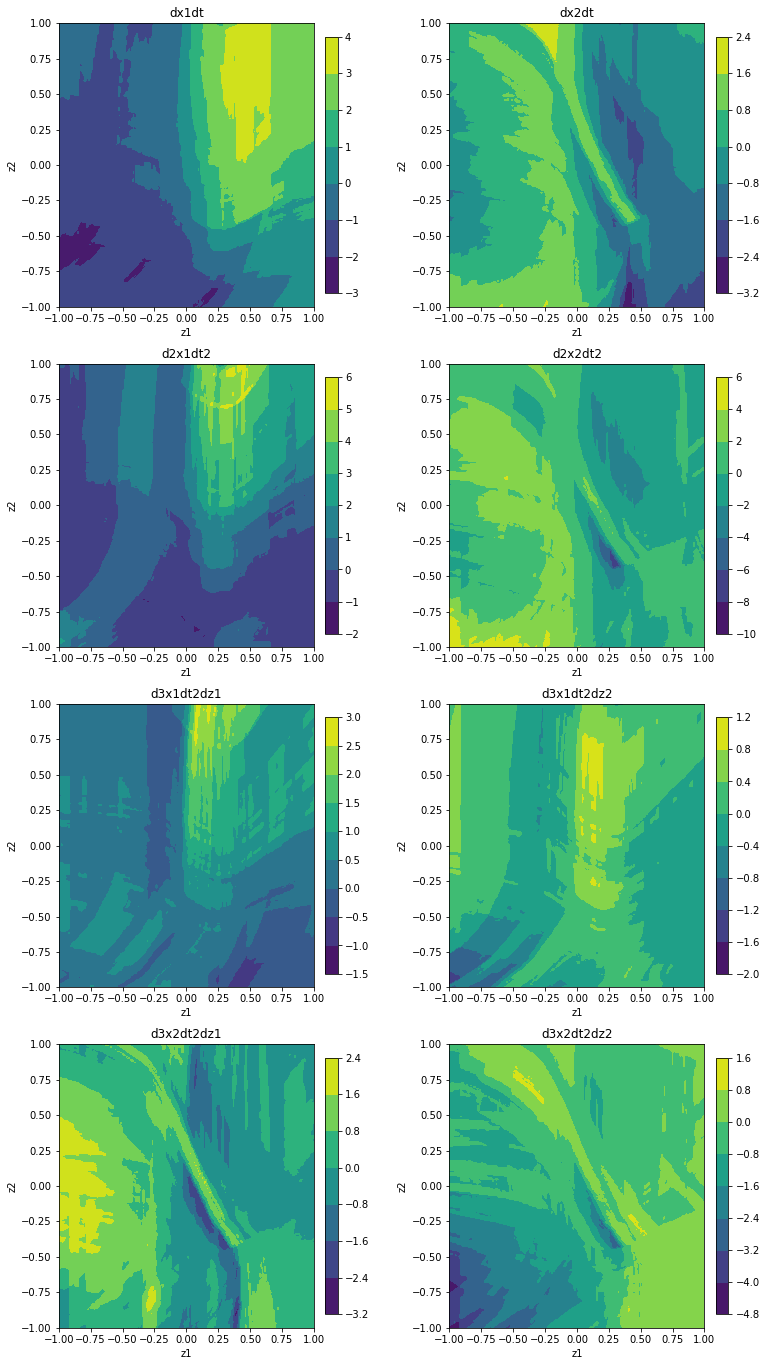

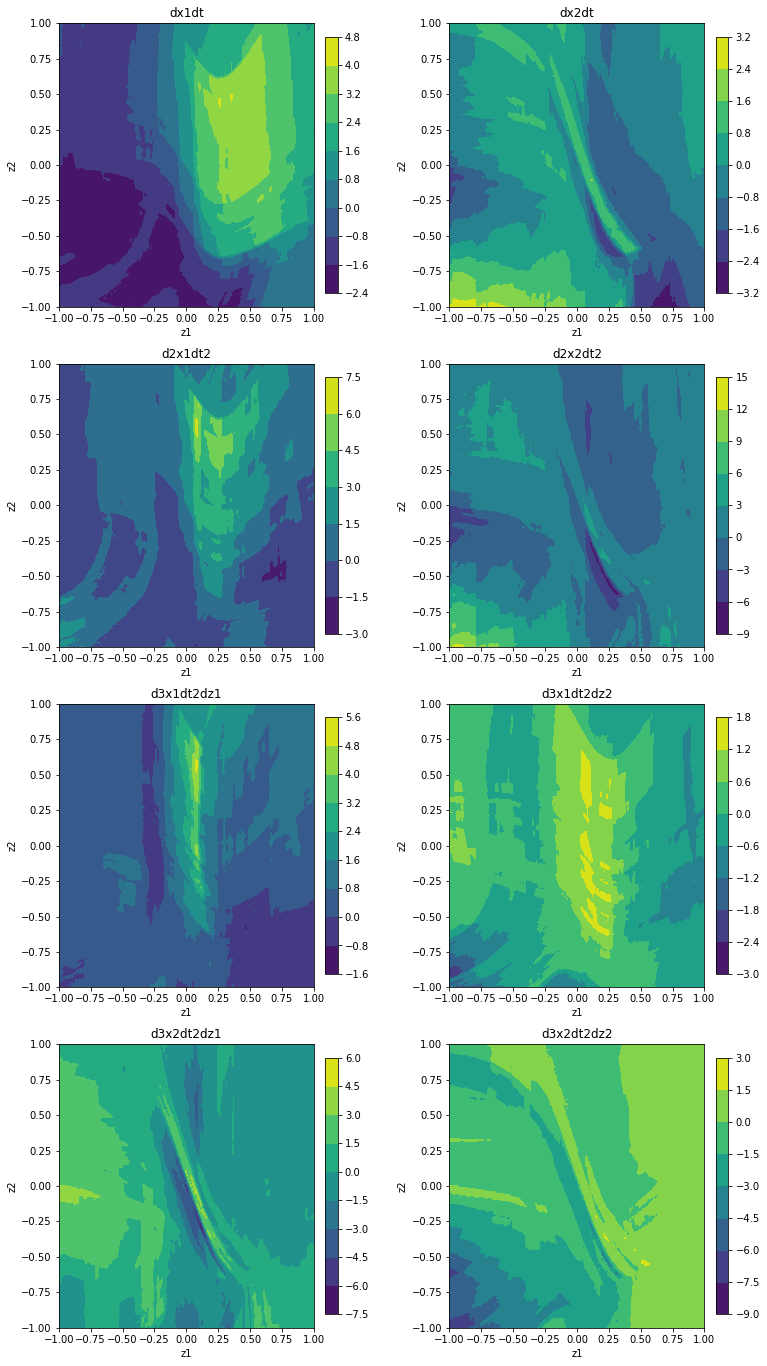

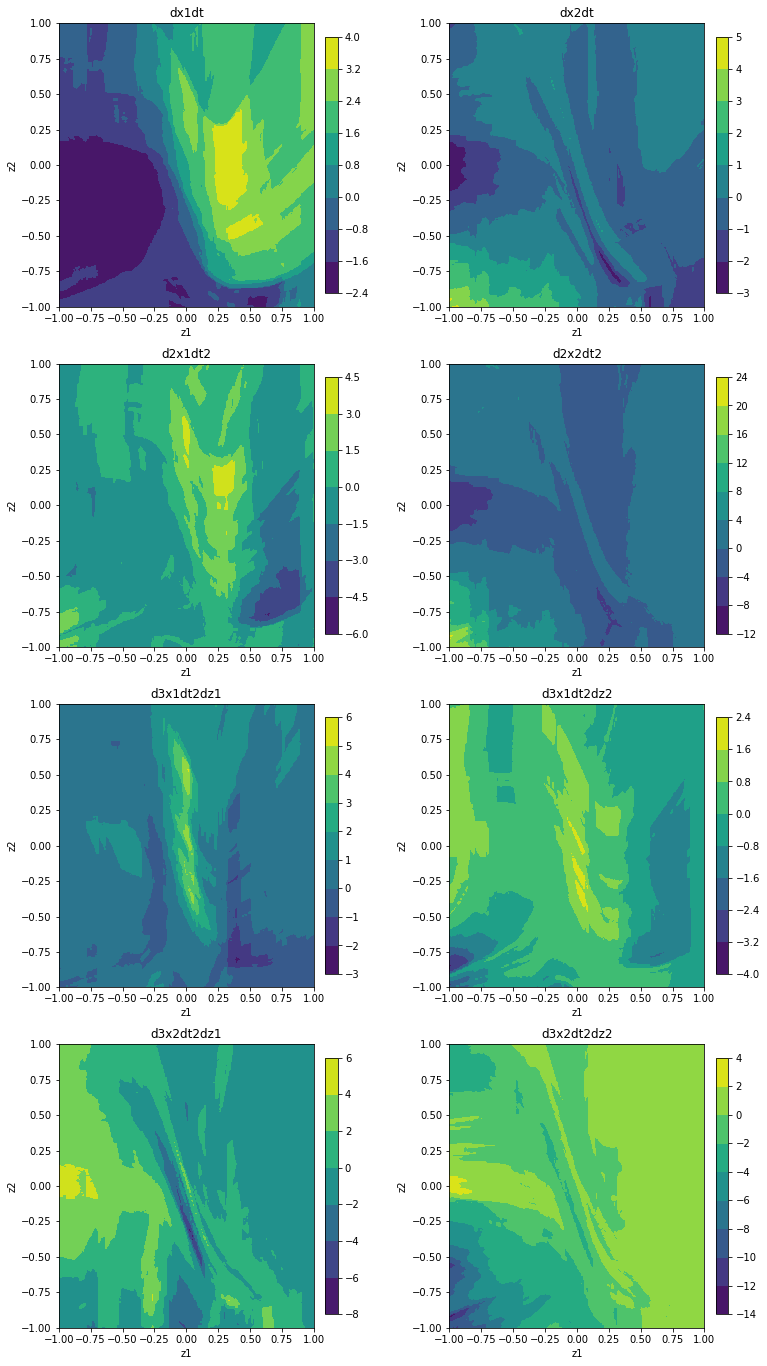

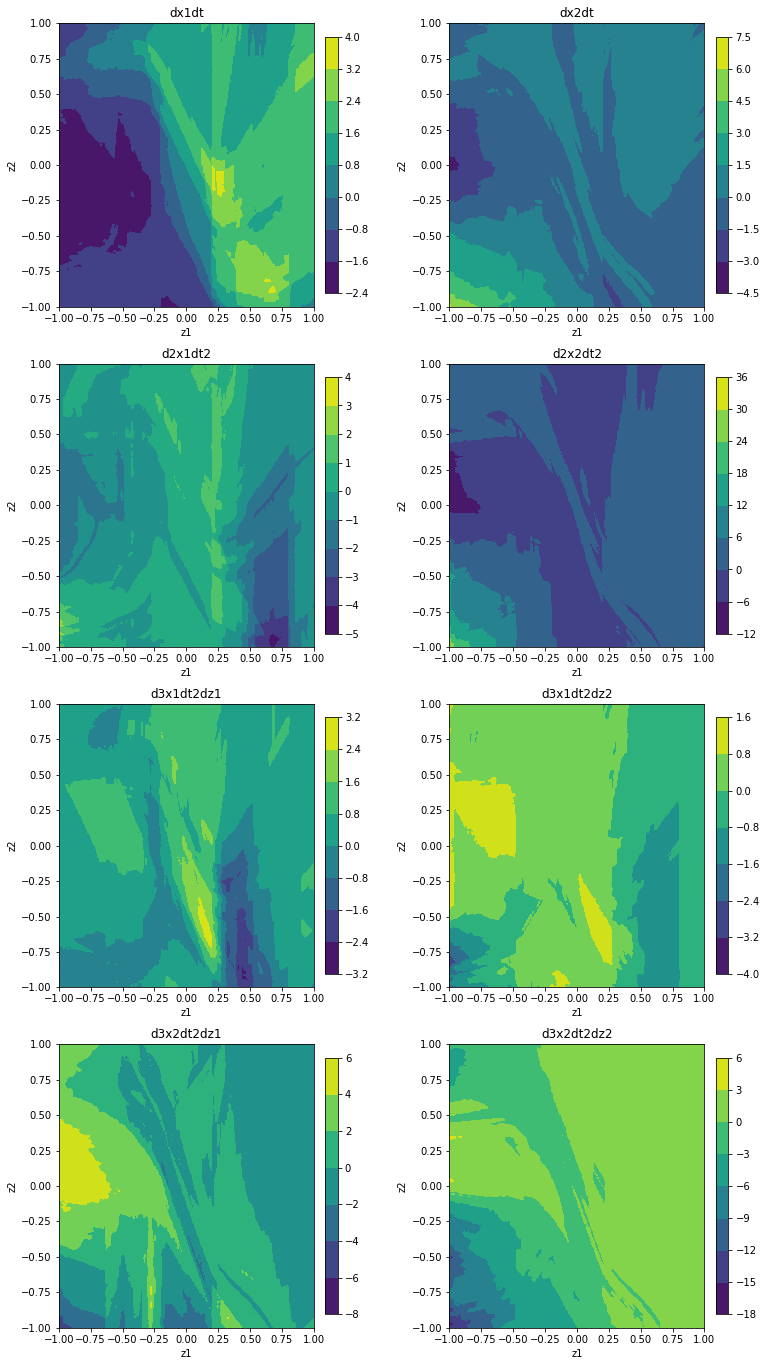

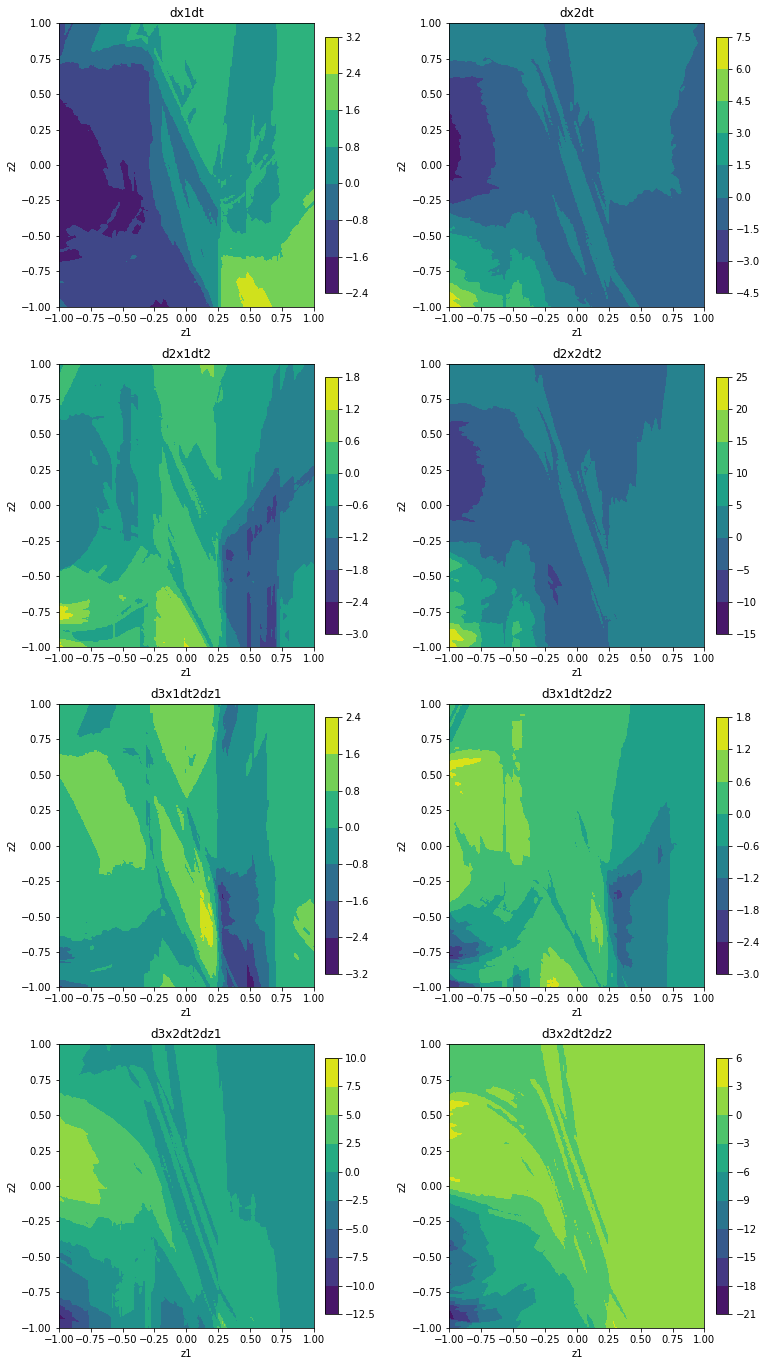

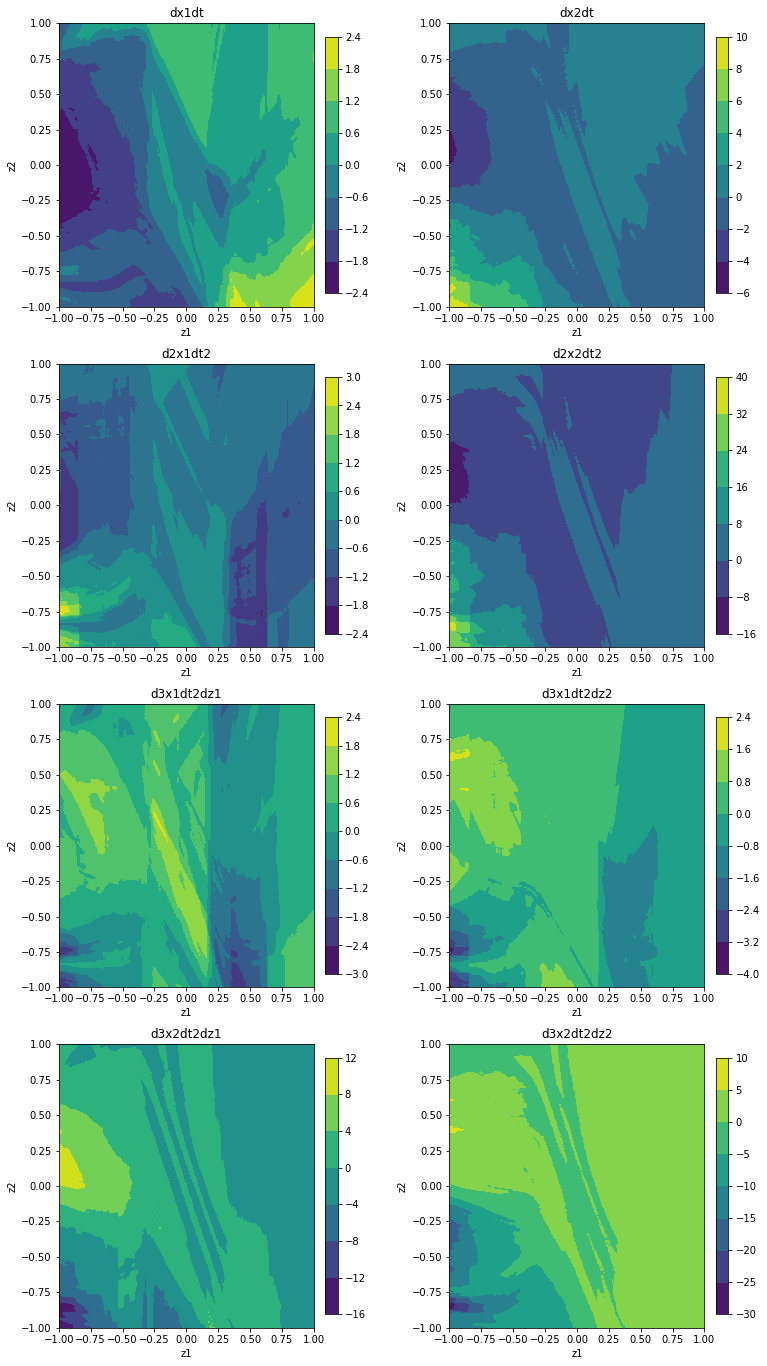

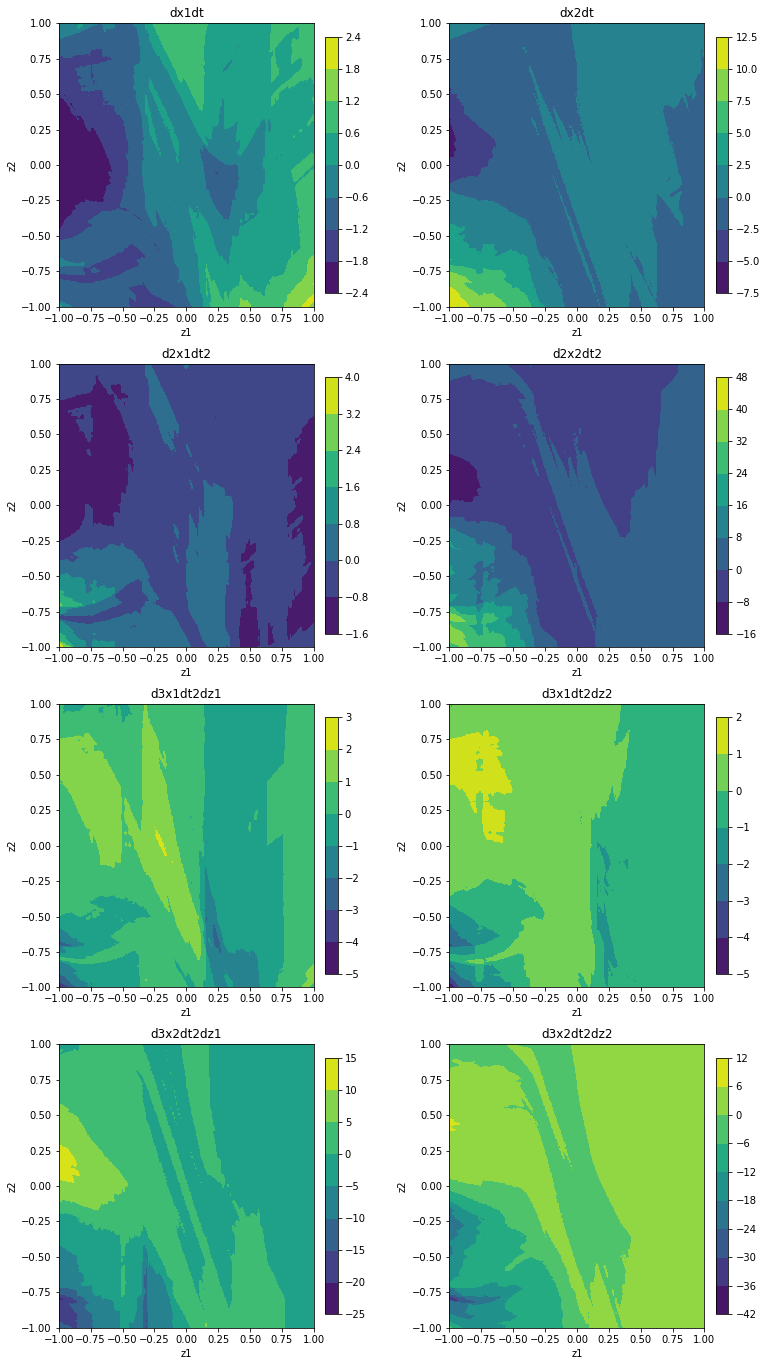

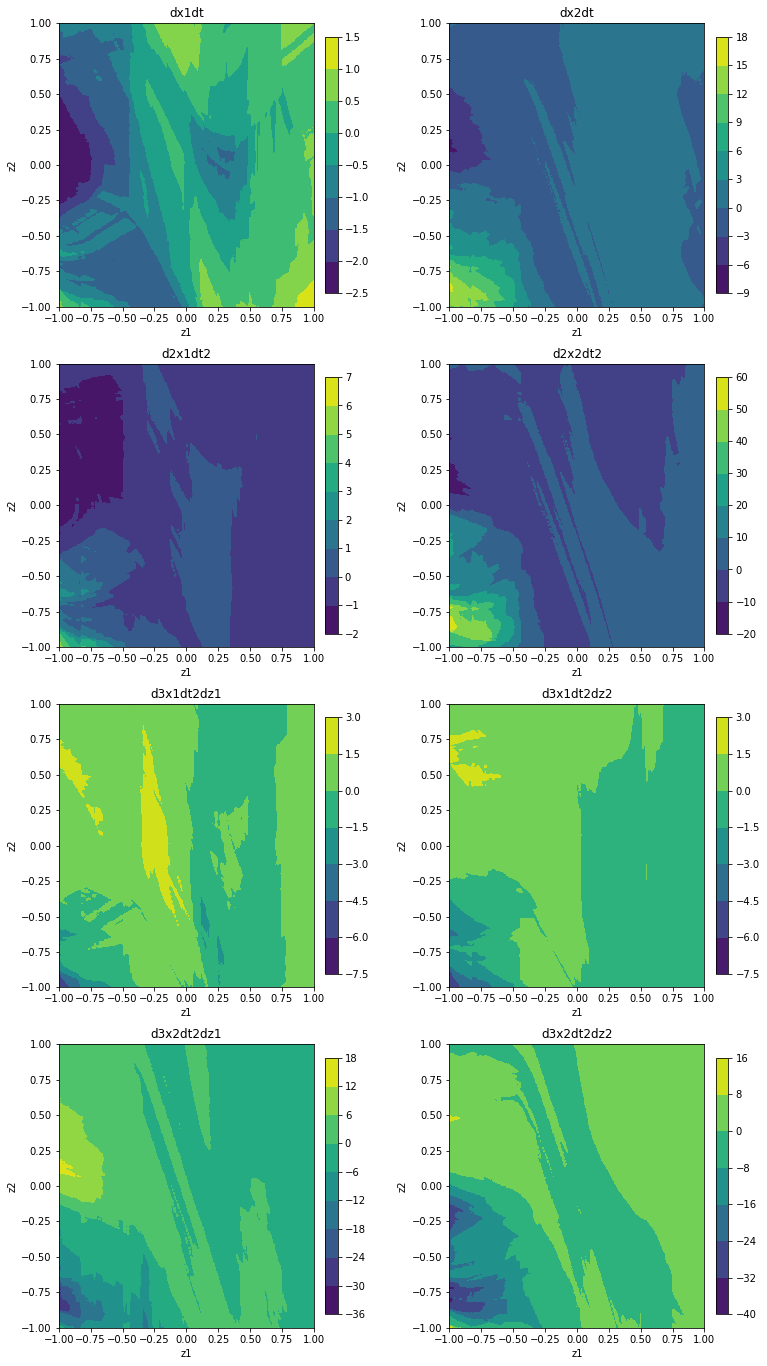

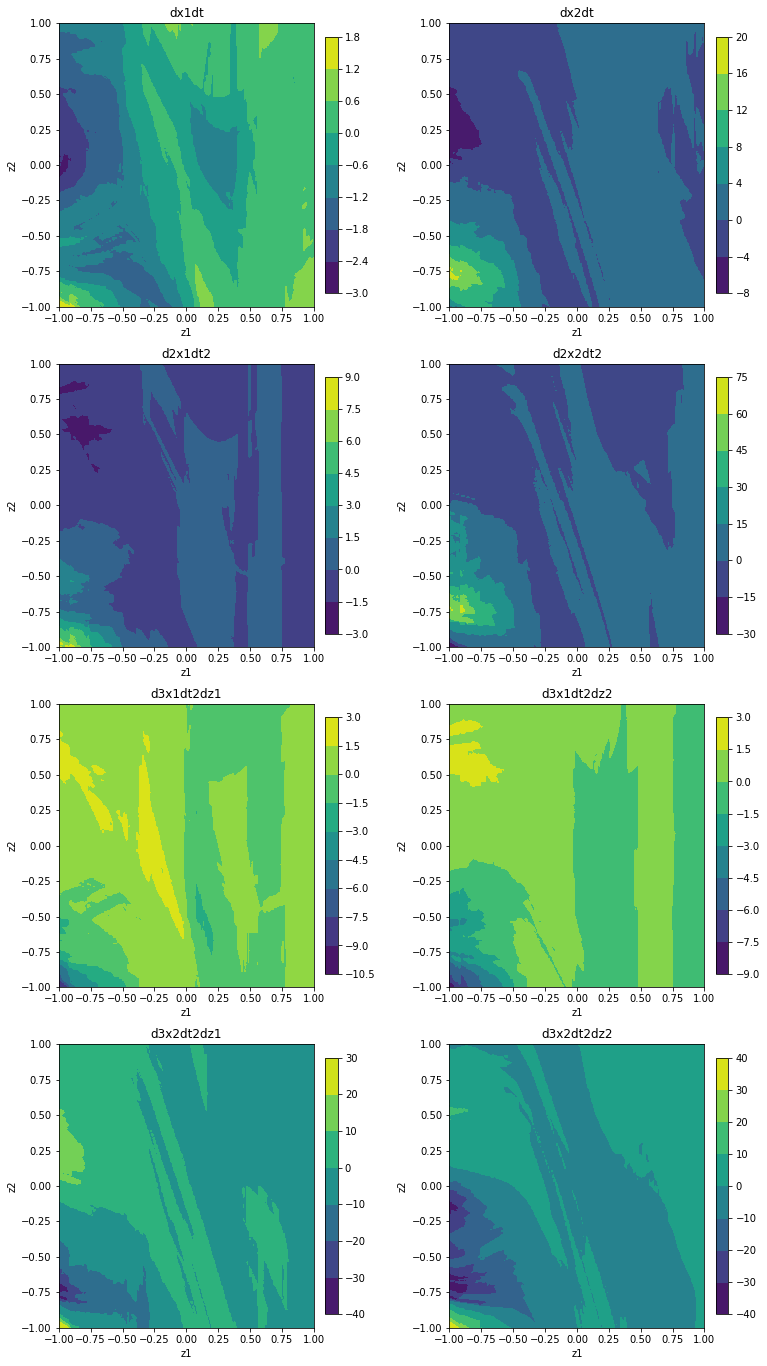

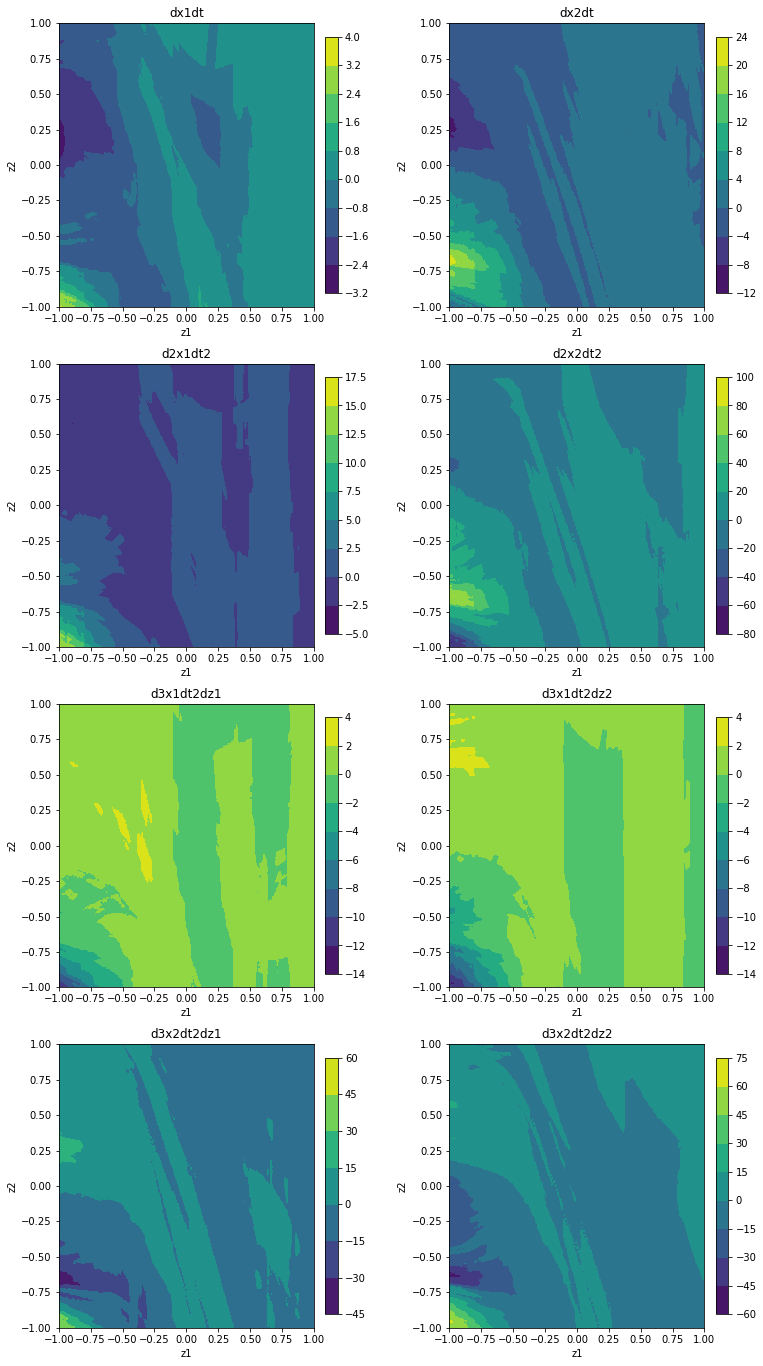

In [10]:
for time in np.arange(0.0,final_time,0.1):
    params[:,0] = time
    g1, g2, v = flow_model.extract_gradient(grid,params)

    # print(g1,g2,v)

    dx1dt = g1.numpy()[:,0,0].reshape(zx.shape[0],zy.shape[0])
    dx2dt = g1.numpy()[:,1,0].reshape(zx.shape[0],zy.shape[0])
    d2x1dt2 = g2.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
    d2x2dt2 = g2.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])

    d3x1dt2dz1 = v.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
    d3x1dt2dz2 = v.numpy()[:,0,0,1].reshape(zx.shape[0],zy.shape[0])
    d3x2dt2dz1 = v.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])
    d3x2dt2dz2 = v.numpy()[:,1,0,1].reshape(zx.shape[0],zy.shape[0])

    fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(12,24))


    cs1 = ax[0,0].contourf(zxv,zyv,dx1dt)#,levels=levels)
    ax[0,0].set_title('dx1dt')
    cs2 = ax[0,1].contourf(zxv,zyv,dx2dt)#,levels=levels)
    ax[0,1].set_title('dx2dt')
    cs3 = ax[1,0].contourf(zxv,zyv,d2x1dt2)#,levels=levels)
    ax[1,0].set_title('d2x1dt2')
    cs4 = ax[1,1].contourf(zxv,zyv,d2x2dt2)#,levels=levels)
    ax[1,1].set_title('d2x2dt2')

    cs5 = ax[2,0].contourf(zxv,zyv,d3x1dt2dz1)#,levels=levels)
    ax[2,0].set_title('d3x1dt2dz1')

    cs6 = ax[2,1].contourf(zxv,zyv,d3x1dt2dz2)#,levels=levels)
    ax[2,1].set_title('d3x1dt2dz2')

    cs7 = ax[3,0].contourf(zxv,zyv,d3x2dt2dz1)#,levels=levels)
    ax[3,0].set_title('d3x2dt2dz1')

    cs8 = ax[3,1].contourf(zxv,zyv,d3x2dt2dz2)#,levels=levels)
    ax[3,1].set_title('d3x2dt2dz2')


    for i in range(4):
        for j in range(2):
            ax[i,j].set_xlabel('z1')
            ax[i,j].set_ylabel('z2')

    fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs3,ax=ax[1,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs4,ax=ax[1,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs5,ax=ax[2,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs6,ax=ax[2,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs7,ax=ax[3,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs8,ax=ax[3,1],fraction=0.046, pad=0.04)
    plt.subplots_adjust(wspace = 0.4)
    plt.show()